# Assignment 2: Speech Production and Models
#### EQ2321 Speech and Audio Signal Processing

Max. grade: 38

# Introduction

Throughout this assignment we will use the speech data in `data["speech8"]` which is sampled at 8 kHz. `speech8` will be used both for tuning (training, optimizing) and evaluating the speech coders (evaluating on the training data is called closed test evaluation). Normally this is considered inappropriate (why?), but
we accept it here for simplicity.
You will frequently be asked to evaluate the SNR which is calculated like
$SNR = 10 \log 10 \frac{\sigma_x^2}{\sigma_q^2}$, where $X(n)$ is input speech to the coder, and $q(n) =
X(n) − \hat{X}(n)$ is the quantization error, where $\hat{X}(n)$ is the quantized speech.
Thus, calculating the SNR amounts to estimating $\sigma_x^2$, and $\sigma_q^2$.
Please note that the last part of the assignment may be the most time
consuming. There you are asked to design a forward gain and filter adaptive
DPCM coder and you are not given many instructions. Make sure you allocate
enough time for this last part!

## The Uniform Scalar Quantizer (4 pts)

In this task we implement the simplest quantizer of all: the uniform scalar
quantizer (USQ). USQs will be used frequently in this assignment.
Encoding and transmission by USQ is sometimes called Pulse Code Modulation (PCM).

In [1]:
import numpy as np
import pickle as pkl
import sounddevice as sd

In [2]:
def read_assignment_file(fname):
    with open(fname,"rb") as f:
        d=pkl.load(f)
    return d

data = read_assignment_file("./assignment2.pkl")
print(data["speech8"],'check speech8' '\n', data["speech8"].shape, 'shape of speech8')

def play_wav(x,fs):
    sd.play(x.astype(np.int16),fs)

play_wav(data['speech8'],8000)      # check speech8

[[  1.60155162]
 [  2.62439824]
 [  1.43115507]
 ...
 [-19.6068527 ]
 [ -0.22280581]
 [  0.41062539]] check speech8
 (46030, 1) shape of speech8


### Question 1

Implement a uniform scalar encoder:

```python
def sq_enc(xin, n_bits, xmax, m):
    """
    xin is a vector with the original speech samples,
    n_bits is the number of bits available to quantize one sample in the quantizer (i.e., the rate),
    xmax and m define the range of the quantizer from m-xmax to m+xmax,
       so that the width of each quantization interval is ∆ = 2 × xmax/L,
           where L is the number of quantization intervals and corresponding reconstruction values.
       m defines the mean (or offset) of the quantizer reconstruction levels.

    The function should return the index of the chosen quantization level.
    """

    return idx
```

Setting m = 0 defines a “midrise” quantizer, and m = $\frac{\Delta}{2}$ gives a "midtread" quantizer (see the course book sec. 7.2).


Implement also the corresponding decoder function
```python
def sq_dec(idx, n_bits, xmax, m)
    """See sq_enc for the definition of the inputs.
    outq is the vector with the quantized values for idx.
    """
    return outq
```
The USQ is a highly structured quantizer. The encoder can be imple-
mented essentially by only a scalar division (no multiplications, compar-
isons or loops are needed), making the computational complexity inde-
pendent of the bitrate. Make sure your encoder has a computational
complexity independent of the bitrate!


In [3]:
def sq_enc(xin, n_bits, xmax, m):
    """
    xin is a vector with the original speech samples,
    n_bits is the number of bits available to quantize one sample in the quantizer (i.e., the rate),
    xmax and m define the range of the quantizer from m-xmax to m+xmax,
       so that the width of each quantization interval is ∆ = 2 × xmax/L,
           where L is the number of quantization intervals and corresponding reconstruction values.
       m defines the mean (or offset) of the quantizer reconstruction levels.

    The function should return the index of the chosen quantization level.
    """
    L = 2**n_bits
    offset = m-xmax
    delta = (2*xmax)/L
    n = len(xin)
    idx = np.zeros((n)).astype(np.float64)   # check shape
    # print(idx.shape,'idx matrix shape')
    for i in range(n-1):   # for each sample
        d = xin[i] - offset
        if d < delta:
            idx[i] = 0
        elif d >= (L-1)*delta:
            idx[i] = L-1
        else:
            idx[i] = np.floor(d/delta)
    return idx

x = np.linspace(-6,6,1201)
idx_test = sq_enc(x, 2, 4, 0)


def sq_dec(idx, n_bits, xmax, m):

    """See sq_enc for the definition of the inputs.
    outq is the vector with the quantized values for idx.
    """

    outq = np.zeros_like(idx).astype(np.float64)
    L = 2**n_bits
    delta = 2*xmax/L
    offset = m - xmax
    outq = offset+(2*idx+1)*(delta/2)
    return outq

### Question 2 (4 pts)

Run the encoder and decoder on a ramp signal `x=np.linspace(-6,6,1201)`. Use a `2-bit` quantizer with $x_{max} = 4$.

Plot the quantizer output as a function of the input.

Make sure the output levels are exactly where you expect them to be.

Use a quantizer mean $m=0$. Do a similar plot with $m=1.5$.

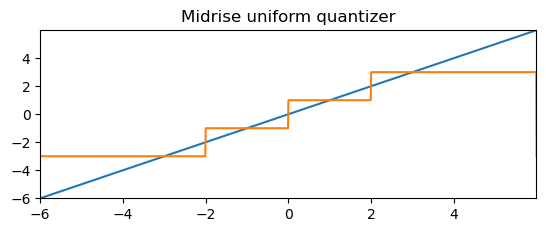

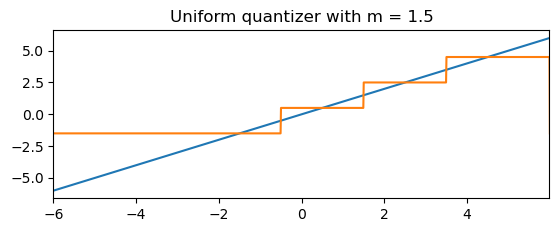

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

x = np.linspace(-6,6,1201)
n_bits = 2
xmax = 4
m1 = 0
m2 = 1.5
idx1 = sq_enc(x,n_bits,xmax,m1)
outq1 = sq_dec(idx1,n_bits,xmax,m1)
idx2 = sq_enc(x,n_bits,xmax,m2)
outq2 = sq_dec(idx2,n_bits,xmax,m2)


plt.figure()
plt.subplot(211)
plt.plot(x,x)
plt.plot(x,outq1)
plt.xlim(-6,5.99)
plt.ylim(-6,5.99)
plt.title('Midrise uniform quantizer')
plt.show()

plt.figure()
plt.subplot(212)
plt.plot(x,x)
plt.xlim(-6,5.99)
plt.plot(x,outq2)
plt.title('Uniform quantizer with m = 1.5')
plt.show()


## Parametric Coding of Speech (23 pts)

In this task we complete our design of the vocoder from assignment 1.
Note that the speech used in this assignment is different from assignment 1 and if
your vocoder analysis is not robust you may have to retune the analysis for this
assignment.
You are encouraged to use your own vocoder.
However, it must produce a quality that is at least as high as our vocoder provided to you.
If not, then you have to get aquainted with our vocoder, and use that in the following.
In practice, a speech coder must operate on a frame-by-frame basis, and transmit compressed data as quickly as possible in order to keep the delay short.
However, you may have implemented your vocoder in an off-line fashion (the pitch estimator is easier to implement like that for example).
This is acceptable also here.

In [5]:
from scipy import signal
from scipy.linalg import solve_toeplitz

def x_corr(x,y,M=10):
    corr = signal.correlate(x, y, mode="full")
    lags = signal.correlation_lags(len(x), len(y), mode="full")
    idx=(lags>=-M) & (lags<=M)
    corr = corr[idx]
    lags=lags[idx]
    return lags[len(lags)//2:], corr[len(lags)//2:]   # truncate，len(lags) = 21, corr(only remain last 11 values)

def analysis(x, alen, ulen, M):
    naf = (len(x)-alen+ulen) // ulen  # Number of analysis frames
    threshold = 0.3
    E, A = np.zeros((naf, 1)), np.zeros((naf, M+1))
    ZC, V, P = [], [], []

    for n in range(naf):
        xf = x[n*ulen:n*ulen+alen, 0].astype(np.float32)
        for i in range(alen):
            E[n, 0] = E[n, 0] + xf[i]**2
        E[n, 0] = E[n, 0] / alen
        n_zero = 0
        xf_find_zero = xf.tolist()
        zero_decider = [xf_find_zero[j] * xf_find_zero[j-1] for j in range(1,alen)]
        for num in zero_decider:
            n_zero += 1 if num < 0 else 0
        ZC.append(n_zero/alen)     # The normalized number of zero crossings
        V.append(1) if n_zero/alen < threshold else V.append(0)
        lags1, r = x_corr(xf, xf, M=M)  # acf
        A[n,:] = np.concatenate([np.ones(1), solve_toeplitz(r[:-1], -r[1:])]).ravel()
        peak_index, peak_value = [], []
        d_find = list(signal.correlate(xf, xf,'full')[alen-1:])
        for i in range(len(d_find)-1):
            if d_find[i]>d_find[i-1] and d_find[i]>d_find[i+1]:   # denote peak
                peak_index.append(i)
                peak_value.append(d_find[i])
        peak_index, peak_value = peak_index[1:], peak_value[1:]
        P.append(peak_index[peak_value.index(max(peak_value))])    # Pitch period in samples
    ZC, V = np.array(ZC), np.array(V)

    return E, ZC, V, A, P

def synthesis(E, V, A, P, ulen):
    n_frames = A.shape[0]
    nexc = np.random.random(n_frames*ulen)
    n1 = 0
    Z = np.array([])
    sound = np.zeros((n_frames*ulen))
    for n in range(0, n_frames):
        pexc, cp = np.zeros((n_frames*ulen)), P[n]
        pexc[0::cp] = 1
        exc = pexc if V[n] == 1 else nexc
        if Z.shape[0] == 0: # 1st iteration
            sound[n1:n1+ulen] = signal.lfilter(np.array([1]), A[n,:], exc[n1:n1+ulen])
            Z = signal.lfiltic(np.array([1]), A[n,:], sound[n1:n1+ulen], x=exc[n1:n1+ulen])
        else:
            sound[n1:n1+ulen], Z = signal.lfilter(np.array([1]), A[n,:], exc[n1:n1+ulen], zi=Z)
        energy_sum = sum([e**2 for e in sound[n1:n1+ulen]])/ulen
        for i in range(ulen):
            sound[n1+i] = sound[n1+i]*((E[n,0]/energy_sum)**0.5)
        n1 += ulen
    return sound

def play_wav(x,fs):
    sd.play(x.astype(np.int16),fs)



### Quantizing the Gain (8 pts)

#### Question 1 (1 pts)

Provide a plot of the histogram of the gain parameter.
Indicate in the plot the range of the quantizer, i.e., mark the outer boundaries $m\pm xmax$ (also mark m).
Note that the pdf has a non-zero mean.

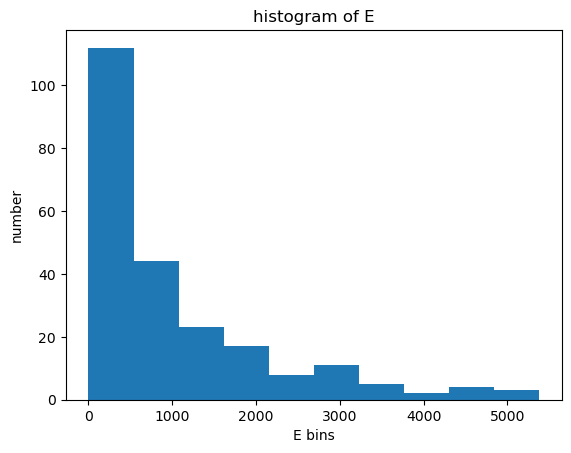

In [6]:
input_sig = data["speech8"]

alen = 256
ulen = 200
M = 10
[E, ZC, V, A, P] = analysis(input_sig, alen, ulen, M)
plt.figure()
plt.hist(np.sqrt(E))            # the energy is displayed in sqrt
# plt.hist(E)
plt.xlabel("E bins")
plt.ylabel("number")
plt.title("histogram of E")
plt.show()


#### Question 2 (2 pts)

Run the vocoder with a uniform scalar gain quantizer according to the design above.
Find the rate at which you cannot hear the quantization distortion.

###### nbits_op = 6    # increase from 2 to 10, 6 is the threshold in which speech become smooth and cannot hear quantization distortion

C:\Users\57412\anaconda3\envs\speech_processing\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in sqrt
  


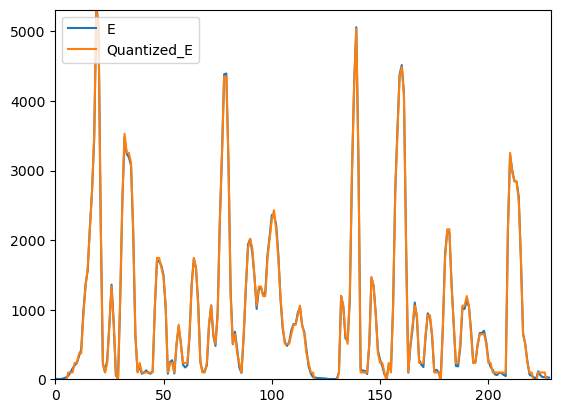

(45800,)


In [7]:
nbits_op = 6    # increase from 2 to 10, 6 is the threshold
# idx_E1 = sq_enc(E,n_bits,xmax_E,mean_E)   # quantize E with 2bits
# outq_E1 = sq_dec(idx_E1, n_bits, xmax_E,mean_E)
mean_E = np.mean(np.sqrt(E))
xmax_E = np.max(np.sqrt(E)) - mean_E
# print(np.sqrt(E), 'shape of E')
# print(np.sqrt(mean_E),'mean','\n', np.sqrt(xmax_E),'xmax')
idx_E_opt= sq_enc(np.sqrt(E),nbits_op,xmax_E,mean_E)   # quantize E with 6bits
outq_E_opt = np.expand_dims(sq_dec(idx_E_opt, nbits_op, xmax_E,mean_E),axis=1)
# expand dims so as to have the same dimension with E

plt.figure()
line1, = plt.plot(np.sqrt(E[:,0]))
line2, = plt.plot(outq_E_opt[:,0])
plt.legend([line1, line2], ["E", "Quantized_E"], loc='upper left')
plt.xlim(0,len(np.sqrt(outq_E_opt[:,0])))
plt.ylim(0,np.max(outq_E_opt))
plt.show()

# play the reconstructed speech
output_E_original = synthesis(E, V, A, P, ulen)
output_sig = synthesis(outq_E_opt**2, V, A, P, ulen)

fs = 8000
# play_wav(input_sig,fs)   # original speech
# play_wav(output_E_original, fs)
print(output_sig.shape)
play_wav(output_sig, fs)

#### Question 3 (1 pts)

Take the logarithm of the gain parameter prior to quantization (does not matter which base).
Provide a plot of the histogram of the gain parameter in the log-domain.
Indicate the range of this quantizer as above.

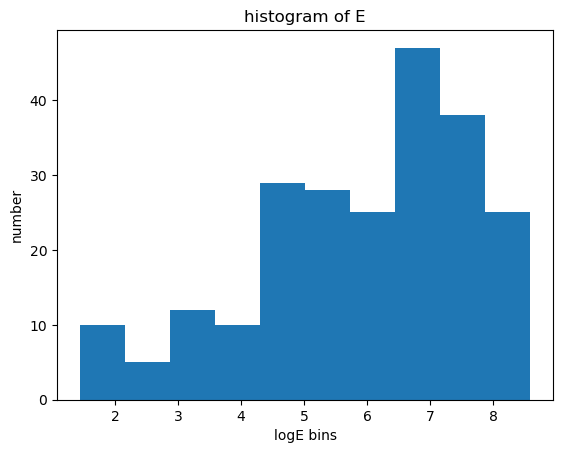

In [8]:
input_sig = data["speech8"]

alen = 256
ulen = 200
M = 10
[E, ZC, V, A, P] = analysis(input_sig, alen, ulen, M)
E_log = np.log(np.sqrt(E))     # log domain

plt.figure()
plt.hist(E_log)
plt.xlabel("logE bins")
plt.ylabel("number")
plt.title("histogram of E")
plt.show()


#### Question 4 (2 pts)

Run the vocoder with a uniform scalar log-gain quantizer according to the design above.
Find the rate at which you cannot hear the quantization distortion.
Make sure to modify the decoder accordingly (apply the exp function to the quantized log-gain).

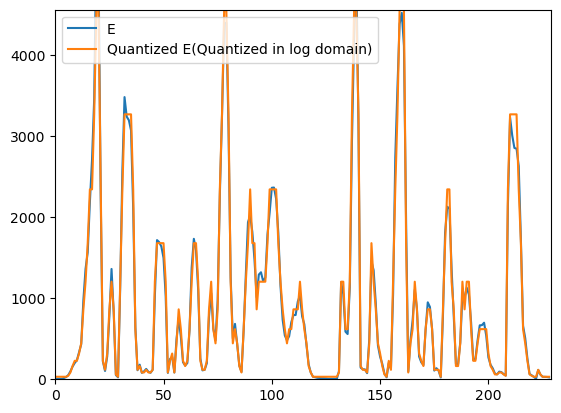

In [9]:
nbits_op = 4    # increase from 2 to 10, 4 is the rough threshold

mean_logE = np.mean(E_log)
xmax_logE = np.max(E_log) - mean_logE
idx_logE_opt= sq_enc(E_log,nbits_op,xmax_logE,mean_logE)   # quantize E with 6bits
outq_logE_opt = np.expand_dims(sq_dec(idx_logE_opt, nbits_op, xmax_logE, mean_logE),axis=1)
# expand dims so as to have the same dimension with E

plt.figure()
line3, = plt.plot(np.sqrt(E[:,0]))
line4, = plt.plot(np.exp(outq_logE_opt))
plt.legend([line3, line4], ["E", "Quantized E(Quantized in log domain)"], loc='upper left')
plt.xlim(0,len(np.exp(outq_logE_opt[:,0])))
plt.ylim(0,np.max(np.exp(outq_logE_opt)))
plt.show()

# To hear the quantization error
output_E_original = synthesis(E, V, A, P, ulen)
output_sig = synthesis(np.exp(outq_logE_opt**2), V, A, P, ulen)

fs = 8000
# play_wav(input_sig,fs)   # original speech
# play_wav(output_E_original, fs)
# play_wav(output_sig, fs)

#### Question 5 (2 pts)

Which is better: gain quantization in linear or log domain?

###### Answer:
Gain quantization in log domain is better, since it needs fewer quantization bits to obtain the same effect. In other words, with bits the same, it can generate better reconstructed speech with less quantization error

### Quantizing the Pitch and Voiced/Unvoiced Decision (2 pts)

#### Question 1 (2 pts)

Come up with an efficient way to encode the pitch and voiced/unvoiced decision.

In [10]:
speech_data = data["speech8"]
E,ZC,V,A,P = analysis(x=speech_data, alen=256, ulen=128, M=10)

def run_length_binary(input_seq): # V is a binary sequence, consider run-length code
    rlc, N = [input_seq[0]], 1
    for sym in range(len(input_seq)-1):
        rlc.append(N) if input_seq[sym+1] != input_seq[sym] else None
        N += 1 if input_seq[sym+1] == input_seq[sym] else -N+1
    rlc.append(N)
    return rlc

def run_length_decoder(rlc):
    decode_seq = []
    for rl in range(len(rlc)-1):
            decode_seq += [rlc[0] for l in range(rlc[rl+1])] if rl & 1 == 0 else [abs(rlc[0]-1) for l in range(rlc[rl+1])]
    return decode_seq

def get_optimal_code(source):  # use shannon optimal code to encoder P and the run-length code of V
    pmf, code_len = [], []
    for sym in np.unique(source):
        pmf.append(source.count(sym)/len(source))
    for sym in source:
        code_len.append(np.ceil(-np.log2(source.count(sym)/len(source))))
    return pmf, code_len

V_encoded = run_length_binary(V)
V_decoded = run_length_decoder(V_encoded)
V_pmf, V_bit = get_optimal_code(V_encoded)
P_pmf, P_bit = get_optimal_code(P)
print(sum(V_bit)/len(V), sum(P_bit)/len(P))


0.3407821229050279 6.340782122905028


#### Question 1 (4 pts)

For the quantization of LP parameters, we will use a vector quantizer (VQ).
You do not need to optimize (train) the VQs; that has been done for you, and
the codebooks can be found in the MATLAB variables lsfCB1 and lsfCB2 in
the file assignment2.mat.
The codebooks constitute a multistage VQ.
`lsfCB1` is a 10 bit VQ optimized on 10 dimensional LSF vectors.
`lsfCB2` is a 10 bit second stage residual codebook.

What you need to do is to program an encoding function and a corresponding decoding function for a multistage VQ.
A suitable calling syntax for these functions can be

```python
def encodefilter(A, cb1, cb2):
    return codeA
```

```python
def decodefilter(codeA, cb1, cb2):
    return Aq
```

Here A is a matrix with filter coefficients stored row-wise, and codeA is a two-column matrix with the corresponding code indices, stored row-wise.

Notes:

1. To convert between polynomial (a-) coefficients and LSFs see `poly2lsf` and `lsf2poly`. You migh require toolboxes such as https://pyspectrum.readthedocs.io/en/latest/install.html

2. `poly2lsf` requires the polynomial coefficients to correspond to a minimum phase whitening filter.
This is guaranteed by the autocorrelation LP analysis.
`lsf2poly` requires that the LSFs correspond to a minimum phase whitening filter.
The multistage VQ can output LSFs that do not satisfy this.
As a precaution simply sort the LSFs prior to calling `lsf2poly`.
Also check so they are between 0 and $\pi$.

In [11]:
import spectrum
cb1, cb2 = data['lsfCB1'], data['lsfCB2']

def encode_filter(A, cb1, cb2):
    codeA = []
    for i in range(A.shape[0]):
        A_lsf = spectrum.poly2lsf(A[i, :])
        distance1 = np.sqrt(np.sum((A_lsf-cb1)**2, axis=1))
        min_dist_idx = list(distance1).index(np.min(distance1))
        residual = A_lsf - cb1[min_dist_idx, :]
        distance2 = np.sqrt(np.sum((residual-cb2)**2, axis=1))
        min_res_idx = list(distance2).index(np.min(distance2))
        codeA.append([min_dist_idx, min_res_idx])
    return np.array(codeA)

def decode_filter(codeA, cb1, cb2):
    Aq = []
    for i in range(codeA.shape[0]):
        Aq.append(spectrum.lsf2poly(cb1[codeA[i, 0],:]+cb2[codeA[i, 1],:]))
    return np.array(Aq)

print(A[1, :])
codeA = encode_filter(A, cb1, cb2)
print(codeA)
Aq = decode_filter(codeA, cb1, cb2)
print(Aq[1, :])


[ 1.         -0.4036497  -0.16423292 -0.02820244  0.01931674 -0.17517531
 -0.01899151 -0.15841522  0.08827369 -0.02291808 -0.11271957]
[[ 818  331]
 [ 818  663]
 [ 382  759]
 [ 818  516]
 [ 818  516]
 [ 120  887]
 [1017   11]
 [ 415  580]
 [ 611  784]
 [ 611  818]
 [  22  682]
 [ 746  287]
 [ 937  876]
 [ 851  100]
 [ 851  633]
 [ 937  602]
 [ 937  682]
 [ 980  412]
 [ 980  409]
 [ 797  127]
 [ 274  662]
 [ 589  188]
 [ 517  666]
 [ 589  138]
 [ 843  302]
 [ 678  313]
 [ 458  847]
 [ 843  170]
 [ 843  454]
 [  27  889]
 [  27  675]
 [  27  675]
 [  27  514]
 [  27  893]
 [ 797  550]
 [ 930  601]
 [  99  270]
 [1016   77]
 [ 316  394]
 [ 904  195]
 [ 836  340]
 [ 180  287]
 [ 180   73]
 [ 836   36]
 [ 740  656]
 [ 347  489]
 [ 746  251]
 [ 397   26]
 [ 431  186]
 [ 803  579]
 [ 977  492]
 [ 831  245]
 [ 306  155]
 [ 306  847]
 [ 831  399]
 [ 306  618]
 [   7  657]
 [   7   64]
 [ 969  831]
 [ 839  428]
 [  19  682]
 [ 101  655]
 [  12  548]
 [ 738  159]
 [  97  988]
 [  97  935]
 [ 937 

### Optimizing the Bit Allocation (9 pts)

Here you experiment a little with the number of bits to use for each parameter.
Since you are provided with the LSF codebooks, you cannot experiment with the number of bits spent on LP parameter quantization.
LP quantization contributes a lot to the total number of bits, and the choice of LSF codebook size
vs. performance is crucial in vocoder design, but here we keep the LSF codebook
size fixed.
Find a bit allocation (i.e. the number of bits to use in each quantizer) for the gain, pitch, voiced/unvoiced quantizers, such that the quality is the same as when these parameters are unquantized (the effect of the LP parameter quantization is always present).

#### Question 1 (2 pts)

Evaluate the SNR for your design above.

In [12]:
speech_data = data["speech8"]
nbits_op = 6
E,ZC,V,A,P = analysis(x=speech_data, alen=256, ulen=128, M=10)
E_log = np.log(np.sqrt(E))
mean_logE, xmax_logE = np.mean(E_log), np.max(E_log) - mean_logE
idx_logE_opt= sq_enc(E_log,nbits_op,xmax_logE,mean_logE)
outq_logE_opt = np.expand_dims(sq_dec(idx_logE_opt, nbits_op, xmax_logE, mean_logE),axis=1)
E_decoded = (np.exp(outq_logE_opt))**2
V_encoded = run_length_binary(V)
recon_speech = synthesis(E_decoded, V_decoded, Aq, P, ulen=128)

play_wav(recon_speech, fs)

SNR = 10*np.log10(np.var(speech_data[:len(recon_speech),0])/np.var(speech_data[:len(recon_speech),0]-recon_speech))
print('SNR =', SNR)

SNR = -3.0537858466974295


#### Question 2 (3 pts)

What number of bits do you suggest for the pitch? For the gain? For the
voiced/unvoiced decision?

### Answer
SNR is -3.02dB, which means noise is a little larger than signal.
Here we find the 6 bit is the optimal for gain, for the voiced/unvoiced we just need 0.2150 bits, for the pitch we need 6.34 bits.

In [13]:
V_encoded = run_length_binary(V)
V_decoded = run_length_decoder(V_encoded)
V_pmf, V_bit = get_optimal_code(V_encoded)
P_pmf, P_bit = get_optimal_code(P)
print(sum(V_bit)/len(V), sum(P_bit)/len(P))
print("Number of bits for each voiced/unvoiced", sum(V_bit))

0.3407821229050279 6.340782122905028
Number of bits for each voiced/unvoiced 122.0


#### Question 3 (2 pts)

What is the rate in bits per sample of your vocoder with the bit allocation
suggested above? In bits per second?

### Answer
For the whole speech we have 358 frames, and for each frame, we have frame length which is alen=256. Each frame require 20bits for LP coefficients, 6bits for Gain and 6.34bits for Pitch, and 0.215bits for Voiced/Unvoiced.

For each frame, we need 32.515bits, and 32.515/256=0.127 bits per sample.
In bits per second, it is 8000*0.127=1016.1bits

#### Question 4 (2 pts)
Does it make sense to evaluate SNR here? Why or why not?

#### Answer
Not very make sense because here our vocoder just utilize some parameters from the speech to reconstruct it, and it brings a lot of distortion which cause low SNR. More over, in this case SNR cannot precisely represent the quality of the reconstructed speech, for example, if we allocated smaller bits for Gain, the SNR will increase, but the distortion we hear will also increase.

## Speech Waveform Quantization (8 pts +2)

#### Uniform Scalar Quantization of Speech

We will in the following design our quantizers using $x_{max} = \sigma_Xk$ , where $\sigma_X$
is the variance of speech and k is an experimentally tuned parameter (here it is tuned to maximize SNR).

`k` is rate dependent and the SNR optimal `k` for rates 1 to 16 are
```python
l=[0.95, 2.1, ?, 4.95, 6.3, 7.65, 8.85, 9.95, 10.6, 11.0, 11.1, 11.2, 11.15, 11.2,
11.15, 11.15]
```

The optimal (in terms of SNR) value for $R = 3$ is to be found experimentally.
Run the quantizer with different values of k, and measure the SNR, to find the optimal choice.

##### Question 1 (2 pts)

Evaluate the optimal `k` for $R = 3$.

1510.4148374276297
(116, 46030)
(46030, 1)
116
3.5 rate3 that maximize SNR


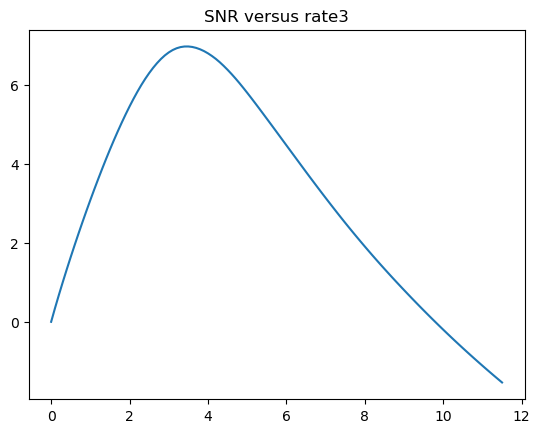

In [14]:
speech_data = data["speech8"]
print(np.sqrt(np.var(speech_data)))

r3 = np.arange(0,11.6,0.1)   # r3 searching from 0 to 11.15
x_max_list = []
x_max_list = [np.sqrt(np.var(speech_data))*k for k in r3]    # searching algorithm
r = 3     # r ,namely bits
m = 0
idx_list = []
idx_list = [sq_enc(speech_data, r, i, m) for i in x_max_list]
outq_list = [sq_dec(idx_list[i], r, x_max_list[i], m) for i in range(0, len(r3))]
outq_array = np.array(outq_list)
print(outq_array.shape)
print(speech_data.shape)
print(outq_array.shape[0])
SNR_list = [10*np.log10(np.var(speech_data)/np.var(outq_array[i,:]- np.squeeze(speech_data))) for i in range(0,outq_array.shape[0])]
plt.figure()
plt.plot(r3, SNR_list)
plt.title('SNR versus rate3')

max_SNR_idx = SNR_list.index(max(SNR_list))
r3_opt = r3[max_SNR_idx]
print(r3_opt, 'rate3 that maximize SNR')

##### Question 2 (2 pts)

Run the quantizer at rates [16, 15, 14, . . ., 2, 1], and evaluate the SNR
for each rate.
Provide a plot of the SNR as a function of rate.

##### Question 3 (2 pts)

Provide a graph of the theoretical SNR in the same plot as the experimental SNR plot.
For the theoretical SNR, assume that the number of quantization levels is high, and that overload is negligible.

16 46030
[1.129229244166177, 3.5695300058136947, 6.9758537391518525, 11.12339917555219, 15.754637690163243, 20.387020092746667, 23.994752815621602, 25.57438071669145, 25.857610869041523, 25.7440639782166, 25.71202025302828, 25.644136933834186, 25.684858075742184, 25.646218862579033, 25.68499851235892, 25.684911505426196]


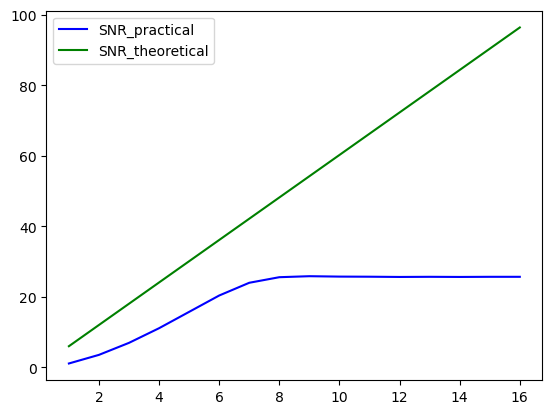

In [15]:
n_bits_list = []
x_max_real_list = []
idx_real_list = []
SNR_real_list = []
speech_data = speech_data.astype(np.float64)
n_bits_list = [i for i in range(1,17)]   # 1 ~ 16
k_opt_list = [0.95, 2.1, r3_opt, 4.95, 6.3, 7.65, 8.85, 9.95, 10.6, 11.0, 11.1, 11.2, 11.15, 11.2, 11.15, 11.15]
x_max_real_list = [np.sqrt(np.var(speech_data))*k for k in k_opt_list]
idx_real_list = [sq_enc(speech_data, n_bits_list[i], x_max_real_list[i], m) for i in range(0,16)]
outq_real_list = [sq_dec(idx_real_list[i], n_bits_list[i], x_max_real_list[i], m) for i in range(0,16)]
outq_real_array = np.array(outq_real_list)
print(len(outq_real_list),len(outq_real_list[0]))
SNR_real_list = [10*np.log10(np.var(speech_data)/np.var(outq_real_array[i,:]- np.squeeze(speech_data))) for i in range(0, outq_real_array.shape[0])]
print(SNR_real_list)
SNR_theory = [10*np.log10(2**(2*i)) for i in n_bits_list]
plt.figure()
line5, = plt.plot(n_bits_list, SNR_real_list, color='blue')
line6, = plt.plot(n_bits_list, SNR_theory, color='green')
plt.legend([line5, line6], ["SNR_practical", "SNR_theoretical"], loc='upper left')
plt.show()

# how to fix when nbits>8 problem

##### Question 4 (1 pts)

At what rate can you not tell the difference between the original and the quantized signal?

###### Answer: when rate = 8, no difference

In [16]:
fs = 8000
# print(outq_real_array.shape)
nbit_select = 8
play_wav(outq_real_array[nbit_select-1,:],fs)

##### Question 5 (1 pts)

Listen to the quantization error signal, $q(n)$.
How would you characterize $q(n)$ for a system operating at rate $R = 1$.
Increase the rate (up to $R \approx 12$) and describe how the character of $q(n)$ changes.

In [17]:
R = 8
q = outq_real_array[R-1,:]- np.squeeze(speech_data)
print(q.shape)
play_wav(q,fs)

(46030,)


###### Answer: when R=1, almost the original speech, as R increases, the speech more like a noise; when R = 8, like white noise; when R = 12, no noise(silent)

##### Question 6 (OPTIONAL 2 pts)

Is it advantageous to have a reconstruction level in the origin for low rates?
Compare (by listening) midrise and midtread quantizers at low bit rates.

16 46030
[1.490349433160876, 4.834338789193093, 9.010112266295687, 13.55240082394349, 18.035840457934597, 22.07534097515463, 24.833576736476573, 25.82689579046982, 25.91505110186639, 25.75809864582019, 25.716589583566677, 25.646154925445238, 25.685925373181956, 25.64674466126599, 25.685261566967846, 25.68504468403217]


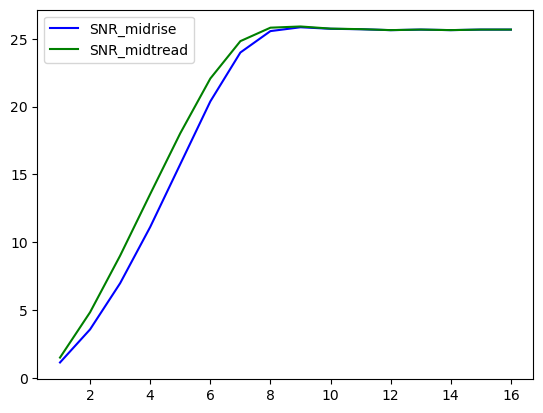

In [18]:
# mid-tread quantizer
m2 = []
m2 = [x_max_real_list[i] / 2**n_bits_list[i] for i in range(0,16)]
idx_real_list2 = [sq_enc(speech_data, n_bits_list[i], x_max_real_list[i], m2[i]) for i in range(0,16)]
outq_real_list2 = [sq_dec(idx_real_list2[i], n_bits_list[i], x_max_real_list[i], m2[i]) for i in range(0,16)]
outq_real_array2 = np.array(outq_real_list2)
print(len(outq_real_list2),len(outq_real_list2[0]))
SNR_real_list2 = [10*np.log10(np.var(speech_data)/np.var(outq_real_array2[i,:]- np.squeeze(speech_data))) for i in range(0, outq_real_array2.shape[0])]
print(SNR_real_list2)
plt.figure()
line7, = plt.plot(n_bits_list, SNR_real_list, color='blue')
line8, = plt.plot(n_bits_list, SNR_real_list2, color='green')
plt.legend([line5, line6], ["SNR_midrise", "SNR_midtread"], loc='upper left')
plt.show()


## Adaptive Open-Loop DPCM (13 pts)
<img src="./openloopdcm.png" alt="alt text" width="800"/>

In this section we will study open-loop Differential Pulse Code Modulation (DPCM).
Open loop DPCM can be viewed as pre-filtering, quantization, and post-filtering, see Figure 1 (the adaptation
mechanism is not shown).
It is called open loop because the quantizer is not part of the prediction loop.

We will want to adapt both the LP coefficients and the gain in a forward fashion.
See the vocoder section for hints on how to forward adapt those.
In general the structure of open loop DPCM is similar to the vocoder structure with
one important difference: vocoders create an artificial replica of the prediction
error signal $d(n)$ (by estimating voiced/unvoiced, the pitch, energy), whereas
open loop DPCM coders quantize each sample of the prediction error signal
and thus try to preserve the original waveform.

We recommend that you reuse as much as possible of the code from the vocoder.

#### Question 1 (4 pts)
You are not given many guidelines here. Give it your best shot and make
sure you can motivate your choice of for example
- analysis frame length,
- update length (to keep things simple make analysis and update lengths
equal, i.e., no overlapping analysis frames),
- window function (for the analysis of certain parameters),
- number of bits to quantize the gain,
- number of bits to quantize the residual,
Use the VQ as before to quantize the LP parameters (thus, you need not
decide prediction order!).

Design the PCM quantizer for the prediction error d(n) according to
$x_{max} = k \sigma_d$ .
Optimize k for $R = 3$ (R meaning the rate of the residual quantizer), by experimenting, so that it sounds good, i.e., do not optimize SNR theoretically.

In [20]:
def xcorr(x,y,M=10):
    """
    Perform Cross-Correlation on x and y
    x    : 1st signal
    y    : 2nd signal

    returns
    lags : lags of correlation             # Returns an array containing cross-correlation lag/displacement indices.
    corr : coefficients of correlation
    """
    corr = signal.correlate(x, y, mode="full")
    lags = signal.correlation_lags(len(x), len(y), mode="full")
    idx=(lags>=-M) & (lags<=M)
    corr = corr[idx]
    lags=lags[idx]
    return lags[len(lags)//2:], corr[len(lags)//2:]   # truncate，len(lags) = 21, corr(only remain last 11 values)

#### Question 2 (1 pts)

Run your system at R = 3.
How would you characterize the reconstructed speech? What does the quantization error sound like?


[ 1.         -0.3723192  -0.29598939 -0.07687174 -0.06226217 -0.0423068
  0.04474507 -0.18987639  0.0853232   0.12861218 -0.16120624]
[ 1.         -0.49742124 -0.11585633  0.01845748 -0.00602299 -0.24690837
  0.09252679 -0.01543014 -0.17035306  0.07373095 -0.09182673]
[ 1.         -0.46498183 -0.25131305 -0.06597456  0.09307632 -0.12522933
 -0.15708637 -0.15252751  0.35333225 -0.18271882  0.00674331]
[ 1.         -0.3602845  -0.12954585 -0.07409396  0.02490218 -0.12115863
 -0.1160654  -0.0619556  -0.04333353  0.00900419 -0.06479629]
[ 1.         -0.39948346 -0.19071463 -0.15871686  0.04808457 -0.11672666
 -0.10815743 -0.04838468  0.20212844 -0.05933565 -0.10008002]
[ 1.         -0.36768932 -0.17756412 -0.06577484 -0.08777347 -0.08893622
 -0.00970045  0.09615023 -0.19850213  0.10322339 -0.10918554]


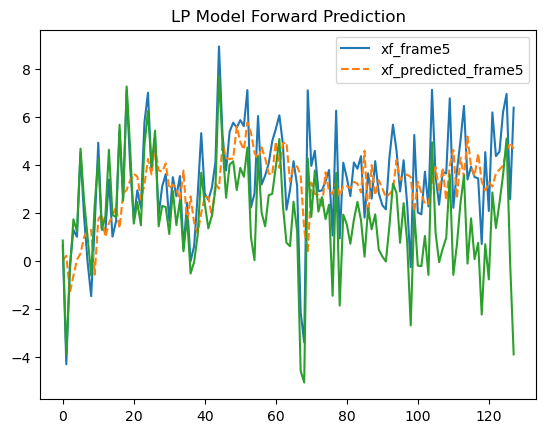

[ 1.         -0.85958587  0.01051535 -0.02487406  0.12870363 -0.18459996
  0.20284102 -0.11245613  0.03531882 -0.0471414  -0.05944079]
[ 1.         -0.72211176  0.0530526  -0.19502936  0.35145888 -0.08616879
  0.14566191 -0.04303966 -0.05404221  0.02410798 -0.04250742]
[ 1.         -0.50679079  0.06619609  0.11217184  0.1252899  -0.08818045
  0.11948744  0.02238452 -0.05841344  0.06363662 -0.00952443]
[ 1.         -0.04914301 -0.0625823   0.06256077  0.29341665  0.15818825
  0.14190953  0.1480296  -0.01740156  0.23761093  0.04616696]
[ 1.00000000e+00  3.70979814e-04  1.41065893e-02 -4.49796942e-02
  2.45533757e-01  8.03350152e-02  2.70723548e-01 -4.53813146e-02
 -1.79916803e-01  2.36528907e-01 -6.76648523e-02]
[ 1.          0.35602785 -0.13168333  0.0139563   0.16524783  0.25770673
  0.28370997  0.12670874 -0.20864763  0.26097506  0.27180781]
[ 1.          0.48656001 -0.10133045 -0.14849229  0.09580603  0.22358856
  0.02650322 -0.11004513 -0.30797929  0.12669744  0.08741651]
[ 1.      

In [86]:
 # open loop DPCM quantize each sample of the prediction error signal
 # the reconstruction error(x^hat - x) should follow the spectral of original signal x

import matplotlib.pyplot as plt
import scipy

def encode_filter(A, cb1, cb2):
    codeA = []
    for i in range(A.shape[0]):
        A_lsf = spectrum.poly2lsf(A[i, :])
        distance1 = np.sqrt(np.sum((A_lsf-cb1)**2, axis=1))
        min_dist_idx = list(distance1).index(np.min(distance1))
        residual = A_lsf - cb1[min_dist_idx, :]
        distance2 = np.sqrt(np.sum((residual-cb2)**2, axis=1))
        min_res_idx = list(distance2).index(np.min(distance2))
        codeA.append([min_dist_idx, min_res_idx])
    return np.array(codeA)

def decode_filter(codeA, cb1, cb2):
    Aq = []
    for i in range(codeA.shape[0]):
        Aq.append(spectrum.lsf2poly(cb1[codeA[i, 0],:]+cb2[codeA[i, 1],:]))
    return np.array(Aq)

def plot_n_frame(n):
    # fig, ax = plt.subplots()
    plt.figure()
    # plt.plot(range(xf_filtered.shape[0]) ,xf_filtered)
    plt.plot(range(xf_filtered.shape[0]), xf_filtered)
    plt.plot(range(xf_hat.shape[0]), xf_hat, linestyle='--')
    plt.legend(['xf_frame5', 'xf_predicted_frame5'])
    plt.title('LP Model Forward Prediction')
    # plt.show()


x = data["speech8"]
alen = 128
ulen = 128
fs = 8000
R = 3

N = len(x)
naf = (N-alen+ulen) // ulen       # Number of analysis frames
n1 = 0
A = np.zeros((naf, M+1))   # M is the prediction order.
# xf_hat = np.zeros((naf,alen))
residual, xmaxs, x_origin = [], [], []

import spectrum
cb1, cb2 = data['lsfCB1'], data['lsfCB2']

for n in range(naf):   # on a frame basis
    xf = x[n1:n1+alen, 0]
    xf = xf.astype(np.float64)
    xf_filtered = xf*signal.windows.boxcar(alen)
    x_origin.append(xf_filtered)
    lags1, r = xcorr(xf_filtered, xf, M=M)  # autocorrelation faixx
    a = np.concatenate([np.ones(1), solve_toeplitz(r[:-1], -r[1:])]).ravel()
    A[n,:] = a # Make sure the polynomial coefficients are in a row vector, store in a matrix
    b = np.hstack([[0], -1*a[1:]])
    # print(b)
    xf_hat = scipy.signal.lfilter(b, [1], xf_filtered)
    res = xf_filtered - xf_hat
    x_max = np.max(res)
    res_q = sq_enc(xin=res, n_bits=3, xmax=x_max, m=0)
    residual.append(res_q)
    xmaxs.append(x_max)
    if n == 5:
        plot_n_frame(5)
    n1 = n1 + ulen

A_q = encode_filter(A, cb1, cb2)
residual = np.array(residual)
A_recon = decode_filter(A_q, cb1, cb2)
x_origin = np.array(x_origin)
# print(A_recon.shape, residual.shape)
# print(x_origin.shape)

y_array = None
for n in range(A_recon.shape[0]):

    a_param = A_recon[n, :]
    print(a_param)
    # a_param = np.hstack([[1], a_param[1:]])
    d_hat = residual[n, :]
    d_hat = sq_dec(d_hat, 3, xmaxs[n], 0)
    y = scipy.signal.lfilter([1], a_param, d_hat)
    if n == 0:
        y_array = y
    else:
        y_array = np.concatenate((y_array, y), axis=0)
    if n == 5:
        plt.plot(y)
        plt.show()
    pred_error = y - x_origin[n,]

play_wav(y_array, fs)

#### Question 3 (2 pts)

What shape does the quantization error spectrum have?
Plot a DFT based spectrum of the error for a voiced frame.
What does theory say?

#### Question 4 (2 pts)

Measure the SNR of your system.
Compare with the SNR of PCM at the same rate.
Comments?

#### Question 5 (2 pts)

What is the total rate of your coder in bits per sample? In bits per second?

#### Question 6 (2 pts)

Is it better to use the quantized LP coefficients in the encoder filter than to use the unquantized LP coefficients?